## Load packages

In [1]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random
using BenchmarkTools, ProfileView
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234)

┌ Info: Precompiling SourceSeparationINN [0967cf83-991d-4407-9a5d-c519cfeee958]
└ @ Base loading.jl:1423


TaskLocalRNG()

## Load data

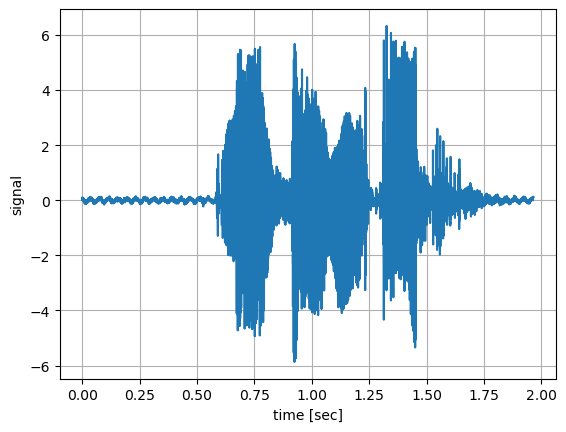

┌ Info: data already processed.
└ @ SourceSeparationINN d:\OneDrive - TU Eindhoven\phd\Projects\SourceSeparationINN\src\data.jl:72
┌ Info: data already processed.
└ @ SourceSeparationINN d:\OneDrive - TU Eindhoven\phd\Projects\SourceSeparationINN\src\data.jl:72
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [2]:
data_train = prepare_data("../data/train/raw", "../data/train/processed"; fs=16000)
data_test = prepare_data("../data/test/raw", "../data/test/processed"; fs=16000)

plt.plot(collect(1:length(data_train[1]))./16000, data_train[1])
plt.grid()
plt.xlabel("time [sec]")
plt.ylabel("signal");

## Create model

In [3]:
function create_model(dim; shift=1, optimizer::Type{<:AbstractOptimizer}=Adam, batch_size::Int=128)

    return Model(dim,
        (   
            NarLayer(dim,
                Model(dim-shift, shift,
                    (
                        DenseLayer(dim-shift, 15; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(15; batch_size=batch_size),
                        DenseLayer(15, 15; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(15; batch_size=batch_size),
                        DenseLayer(15, 15; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(15; batch_size=batch_size),
                        DenseLayer(15, shift; optimizer=optimizer, batch_size=batch_size),
                    )
                )
            ),
        )
    )
end

create_model (generic function with 1 method)

In [4]:
batch_size = 128
dim_in = 16
model = create_model(dim_in);

In [5]:
isinvertible(model), nr_params(model)

(true, 736)

In [6]:
setlr!(model, 1e-4)
loss_function = MSE(batch_size=batch_size)
;

## Show timings

In [ ]:
@benchmark forward!($(model), $(randn(dim_in,batch_size)))

In [ ]:
@benchmark backward($model, $(randn(dim_in,1)))

In [ ]:
@benchmark propagate_error!($(model), $(randn(dim_in,batch_size)))

In [ ]:
@benchmark update!($model)

In [ ]:
@benchmark SourceSeparationINN.train_batch!($model, $(randn(dim_in,batch_size)), $(randn(dim_in,batch_size)), $loss_function)

## Perform training

In [ ]:
train_suite = TrainSuite(
    model,                  # model
    loss_function,          # loss function
    data_train[1:10],             # train data
    data_test,              # test data
    10,                     # number of epochs
    "../logs/"              # path to log directory
);

In [ ]:
run!(train_suite)

In [ ]:
plot_logs(; path="../logs/", logscale=false);